# Internet Consolidation in Africa


We use the AS relationship dataset from CAIDA http://data.caida.org/datasets/as-relationships/serial-1/ to see the relationship between African ISPs and their upstream. To do this, we will take a list of allocated ASes in Africa and run centrality measurements of their providers.

AFRINIC Allocated ASNs:
http://ftp.afrinic.net/pub/stats/afrinic/delegated-afrinic-extended-latest

In [81]:
import os
import numpy as np
import pandas as pd
import collections
import metaknowledge as mk
from datetime import datetime
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# for interactive graphs
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go

# plt.rc("savefig", dpi=600)
# sns.set(font_scale=.75)

import networkx as nx
import itertools

import matplotlib.pyplot as plt
import matplotlib.markers as mkrs

PATH = '../data/data.caida.org/datasets/as-relationships/serial-1/'

wa = ['BF','BJ','CI','CV','GH','GM','GN','GW','LR','ML','NE','NG','SL','SN','TD','TG']
ea = ['BI','DJ','ER','ET','KE','RW','SO','TZ','UG']
na = ['DZ','EG','EH','LY','MA','MR','SD','SS','TN']
sa = ['AO','BW','LS','MW','MZ','NA','SZ','ZA','ZM','ZW']
ca = ['CD','CF','CG','CM','GA','GQ','ST']
io = ['KM','MG','MU','RE','SC','YT']

ccs = [
'EG', 'BJ', 'CI', 'CV', 'GH', 'GM', 'GN', 'GW', 'AO', 'CF', 'CG', 'CM', 'GA', 'GQ', 'TD', 'BI', 'DJ', 'ER', 'ET', 'KM', 'BW', 'MA', 'SD', 'TN', 'LR', 'ML', 'MR', 'NE', 'NG', 'SL', 'SN', 'TG', 'ST', 'KE', 'MG', 'MU', 'MW', 'MZ', 'RE', 'RW', 'SC', 'SO', 'UG', 'LS', 'NA', 'SZ', 'ZA', 'DZ', 'EH', 'LY', 'BF', 'SH', 'CD', 'TZ', 'YT', 'ZM', 'ZW']

#list of TOP core ASNs we selected
top_africa_asns = {37100: ['Seacom','SEACOM-AS', '-o'], 
            30844: ['Liquid', 'LIQUID-AS', '-v' ], 
            3741: ['Internet Solutions', 'IS', '-^'],
            37282: ['Mainone', 'MAINONE', '-p'],
            37662: ['Wiocc', 'WIOCC-AS', '-s'],
            174: ['Cogent', 'COGENT-174', '-+'],
            37271: ['Workonline', 'Workonline', '-x'],
            5713: ['Saix','SAIX-NET', '-D'],
            5511: ['Orange','Opentransit', '-D'],
            8452: ['TE','TE-AS', '-D']
            }

top_core_asns = {20940: ['Akamai','AKAMAI-ASN1', '-o'], 
            13335: ['Cloudflare', 'CLOUDFLARENET', '-v' ], 
            16509: ['Amazon', 'AMAZON-02', '-^'],
            714: ['Apple', 'APPLE-ENGINEERING', '-p'],
            32934: ['Facebook', 'FACEBOOK', '-s'],
            15169: ['Google', 'GOOGLE', '-+'],
            8075: ['Microsoft', 'MICROSOFT-CORP-MSN-AS-BLOCK', '-x'],
            2906: ['Netflix','AS-SSI', '-D']
            }

#list of TOP core ASNs we selected
top_kcore_africa = {
            3741: ['Internet Solutions', 'IS', '-^', 'ISP/DCH'],
            30844: ['Liquid', 'LIQUID-AS', '-v', 'ISP'], 
            37100: ['Seacom','SEACOM-AS', '-o', 'ISP/DCH'], 
            37239: ['ICTGlobe', 'ICTGLOBE', '-p', 'DCH'],
            37468: ['Angola Cables', 'ANGOLA-CABLES', '-p', 'ISP/DCH'],
            37497: ['Network Platforms', 'NetworkPlatforms', '-s', 'COM'],
            37680: ['Cool Ideas', 'COOL-IDEAS', '-+', 'ISP'],
            5713: ['Saix','SAIX-NET', '-D', 'ISP/MOB']
}

markers = ["-^","-v","-o","-p","-.","-r","-s","-+","-D","-k"]

def getMaxSeenCC(df, asn):
    df = df.loc[df.network==asn]
    try:
        cc = df[:1].country_code.values[0]
    except IndexError as e:
        cc = ""
    
    return cc

def getDegree(df, date):
    
    df = df.loc[df.date==date]
    g = nx.from_pandas_edgelist(df, source='provider', target='customer', edge_attr=None, create_using=None)
    g.remove_edges_from(nx.selfloop_edges(g))
    
    df_degree = pd.DataFrame(columns=['asn','degree', 'date'])
    for n,d in g.degree():
        df_degree = df_degree.append({'asn':n, 'degree':d, 'date':date}, ignore_index=True)
    
    df_degree.sort_values('degree', ascending=False, inplace=True)
    return df_degree
    
def plotAsn(df, asn):
    data = df.loc[df.asn==asn]
    plt.plot(data.index, data.values)   

### Get the degree distribution of the nodes

In [2]:
### Load the merged CAIDA, delegated file and select only African providers/customers
#df = pd.read_csv('data/caida_delegated.csv')
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
df_africa = pd.read_csv('../data/asn_relationship_africa.csv', parse_dates=['date'], date_parser=dateparse)
df_africa.head()

,provider,provider_cc,provider_name,customer,customer_cc,customer_name,type,date
0,42,US,WOODYNET-1,2905,ZA,TICSA-ASN,0,2006-02-01
1,42,US,WOODYNET-1,3741,ZA,IS,0,2006-02-01
2,174,US,COGENT-174,5713,ZA,SAIX-NET,-1,2006-02-01
3,209,US,CENTURYLINK-US-LEGACY-QWEST,30998,NG,NAL-AS,-1,2006-02-01
4,286,NL,KPN,3741,ZA,IS,0,2006-02-01


In [16]:
providers = df_africa.iloc[:,[0,1,2]]
providers.columns=['asn', 'cc', 'name']
customers = df_africa.iloc[:,[3,4,5]]
customers.columns=['asn', 'cc', 'name']
df_asns = pd.concat([providers, customers], axis=0)
df_asns.drop_duplicates(inplace=True)

In [3]:
dates = df_africa.iloc[:]['date']
dates.drop_duplicates(inplace=True)
dates.head()

0      2006-02-01
469    2013-02-01
2619   2000-04-01
2692   2006-05-01
3219   2013-05-01
Name: date, dtype: datetime64[ns]

In [23]:
df_array = []
for date in dates.values:
    df_deg = getDegree(df_africa, date)
    df_array.append(df_deg)
df_degree = pd.concat(df_array, axis=0)
df_degree.sort_values(by='date', ascending=True, inplace=True)
#df_degree = df_degree.set_index('date')
df_degree.head()

,asn,degree,date
9,2686,1,1998-01-01
21,3561,2,1998-01-01
23,6713,2,1998-01-01
24,7020,2,1998-01-01
30,4005,2,1998-01-01


In [26]:
df_degree['asn'] = df_degree['asn'].astype('int64')

In [30]:
df_degree = df_degree.merge(df_asns, how='left', on='asn')
df_degree.head()

,asn,degree,date,cc,name
0,2686,1,1998-01-01,\N,ATGS-MMD-AS
1,3561,2,1998-01-01,US,CENTURYLINK-LEGACY-SAVVIS
2,6713,2,1998-01-01,MA,IAM-AS
3,7020,2,1998-01-01,ZA,QDATA-AS
4,4005,2,1998-01-01,\N,GLOBAL-SPLK


In [ ]:
df_degree.loc[df_degree.date=='2019-08-01'].sort_values(by='degree', ascending=False)

### Top African providers
Based on degree centrality

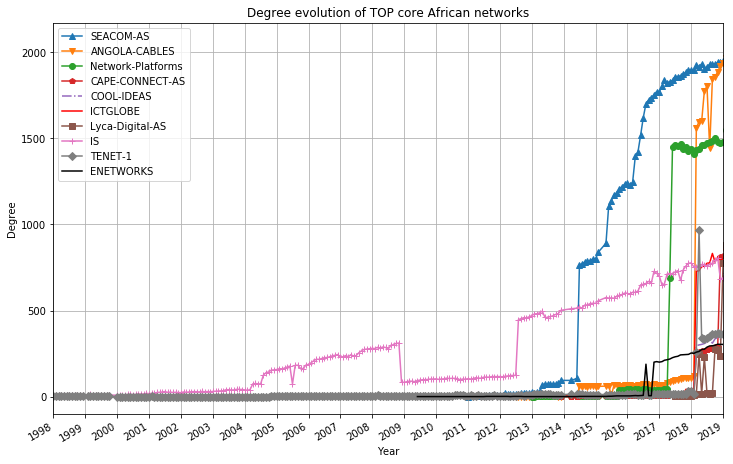

In [82]:
fig, ax = plt.subplots(figsize=(12, 8))

top10 = df_degree.loc[df_degree.date=='2019-08-01'].sort_values(by='degree', ascending=False)[:10]

i=0
for asn in top10.asn.values:
    data = df_degree.loc[df_degree.asn == asn].sort_values(by=['date'])
    label = top10.loc[top10.asn == asn].name.values[0]
    ax.plot(data.date.values, data.degree.values, markers[i], label=label)
    i=i+1
    
# Format the x axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

# # round to nearest years.
datemin = np.datetime64(df_degree.date.values[0], 'Y')
datemax = np.datetime64(df_degree.date.values[-1], 'Y') 
ax.set_xlim(datemin, datemax)    

ax.grid(True)  

plt.ylabel('Degree')
plt.xlabel('Year')
plt.xticks(rotation='vertical')
# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.title('Degree evolution of TOP core African networks')
plt.legend(loc='best')
plt.savefig('plots/degree_evolution_african_networks.png')
plt.show()    

### Top core ASNs

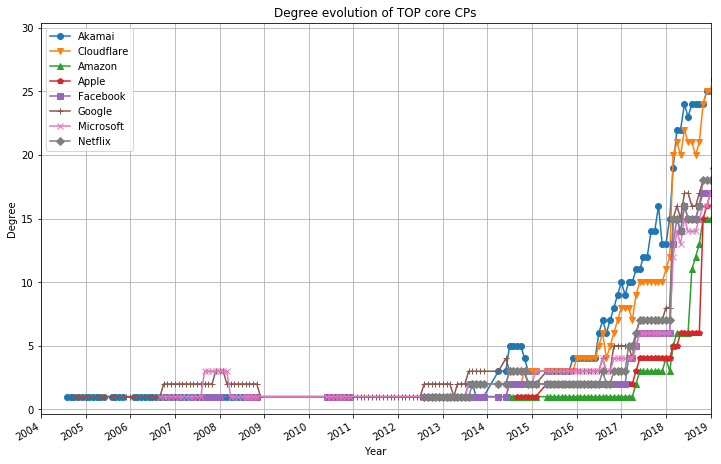

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))

for asn in top_core_asns.keys():
    data = df_degree.loc[df_degree.asn == asn].sort_values(by=['date'])
    label = top_core_asns[asn][0]
#     ax = data.plot(ax=ax, kind='line', x='date', y='kmax', label=label)
    ax.plot(data.date.values, data.degree.values, top_core_asns[asn][2], label=label)

# Format the x axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

# # round to nearest years.
datemin = np.datetime64(df_degree.date.values[0], 'Y')
datemax = np.datetime64(df_degree.date.values[-1], 'Y')
ax.set_xlim(datemin+6, datemax)    

plt.grid()
plt.ylabel('Degree')
plt.xlabel('Year')
plt.xticks(rotation='vertical')
fig.autofmt_xdate()

plt.title('Degree evolution of TOP core CPs')
plt.legend(loc='best')
plt.savefig('plots/degree_evolution.png')
plt.show()    

## Transit Only
Select transit relationship only

In [38]:
df_transit = df_africa.loc[df_africa.type == -1]
dates = df_transit.iloc[:]['date']
dates.drop_duplicates(inplace=True)

In [40]:
df_array = []
for date in dates.values:
    df_deg = getDegree(df_transit, date)
    df_array.append(df_deg)
df_degree_t = pd.concat(df_array, axis=0)
df_degree_t.sort_values(by='date', ascending=True, inplace=True)
#df_degree = df_degree.set_index('date')
df_degree_t.head()

,asn,degree,date
1,6879,1,1998-01-01
11,6351,2,1998-01-01
12,3561,2,1998-01-01
14,6713,2,1998-01-01
19,8094,2,1998-01-01


In [44]:
df_degree_t['asn'] = df_degree_t['asn'].astype('int64')
df_degree_t = df_degree_t.merge(df_asns, how='left', on='asn')

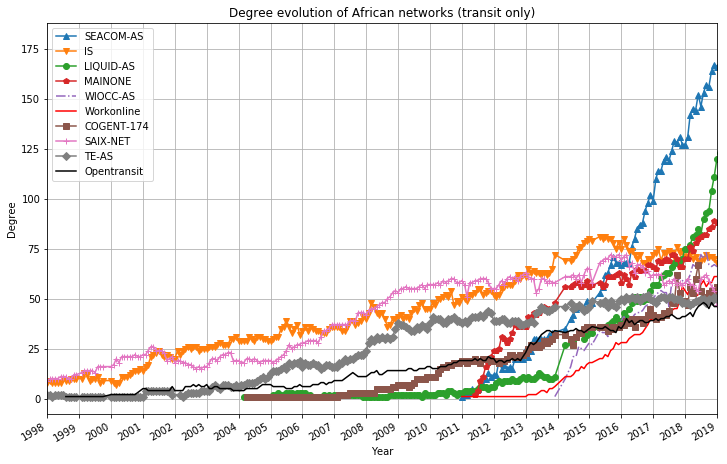

In [83]:
fig, ax = plt.subplots(figsize=(12, 8))

top10 = df_degree_t.loc[df_degree_t.date=='2019-08-01'].sort_values(by='degree', ascending=False)[:10]

i=0
for asn in top10.asn.values:
    data = df_degree_t.loc[df_degree_t.asn == asn].sort_values(by=['date'])
    label = top10.loc[top10.asn == asn].name.values[0]
    ax.plot(data.date.values, data.degree.values, markers[i], label=label)
    i=i+1
    
# Format the x axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

# # round to nearest years.
datemin = np.datetime64(df_degree_t.date.values[0], 'Y')
datemax = np.datetime64(df_degree_t.date.values[-1], 'Y') 
ax.set_xlim(datemin, datemax)    

ax.grid(True)  

plt.ylabel('Degree')
plt.xlabel('Year')
plt.xticks(rotation='vertical')
# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.title('Degree evolution of African networks (transit only)')
plt.legend(loc='best')
plt.savefig('plots/degree_evolution_african_networks_transit.png')
plt.show()    

## Peering only

In [84]:
df_peering = df_africa.loc[df_africa.type == 0]
dates = df_peering.iloc[:]['date']
dates.drop_duplicates(inplace=True)

In [85]:
df_array = []
for date in dates.values:
    df_deg = getDegree(df_peering, date)
    df_array.append(df_deg)
df_degree_p = pd.concat(df_array, axis=0)
df_degree_p.sort_values(by='date', ascending=True, inplace=True)
#df_degree = df_degree.set_index('date')
df_degree_p['asn'] = df_degree_p['asn'].astype('int64')
df_degree_p = df_degree_p.merge(df_asns, how='left', on='asn')
df_degree_p.head()

,asn,degree,date,cc,name
0,2018,1,1998-01-01,ZA,TENET-1
1,6187,1,1998-01-01,ZA,SPRINT-ZA
2,6180,1,1998-01-01,ZA,NIS-CT
3,5710,1,1998-01-01,US,NBTBA-ASN
4,4178,1,1998-01-01,ZA,AZTEC


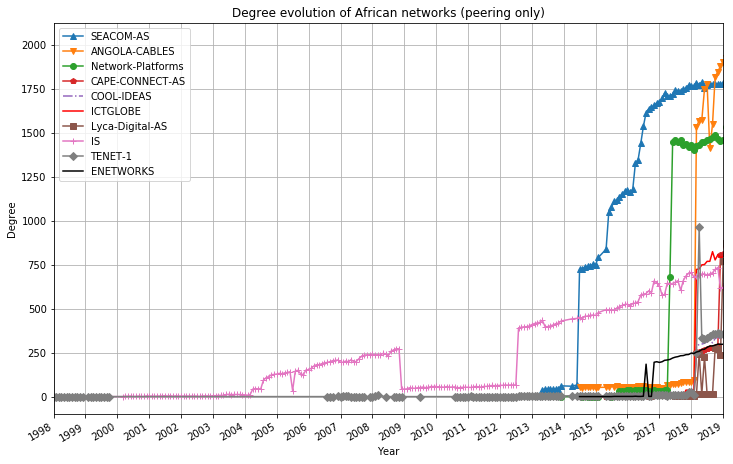

In [86]:
fig, ax = plt.subplots(figsize=(12, 8))

top10 = df_degree_p.loc[df_degree_p.date=='2019-08-01'].sort_values(by='degree', ascending=False)[:10]

i=0
for asn in top10.asn.values:
    data = df_degree_p.loc[df_degree_p.asn == asn].sort_values(by=['date'])
    label = top10.loc[top10.asn == asn].name.values[0]
    ax.plot(data.date.values, data.degree.values, markers[i], label=label)
    i=i+1
    
# Format the x axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

# # round to nearest years.
datemin = np.datetime64(df_degree_p.date.values[0], 'Y')
datemax = np.datetime64(df_degree_p.date.values[-1], 'Y') 
ax.set_xlim(datemin, datemax)    

ax.grid(True)  

plt.ylabel('Degree')
plt.xlabel('Year')
plt.xticks(rotation='vertical')
# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.title('Degree evolution of African networks (peering only)')
plt.legend(loc='best')
plt.savefig('plots/degree_evolution_african_networks_peering.png')
plt.show()    

In [93]:
g = nx.from_pandas_edgelist(df_africa.loc[df_africa.date == '2019-08-01'], source='provider_name', target='customer_name', edge_attr=None, create_using=None)
g.remove_edges_from(nx.selfloop_edges(g))

#### Degree distribution

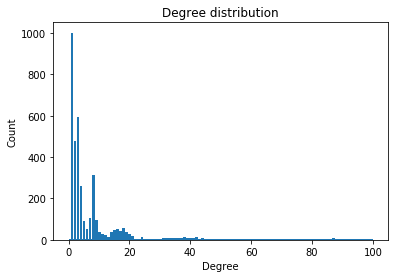

In [94]:
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

n_bins = 500

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig, ax1 = plt.subplots(figsize=(6, 4))

#plot the cumulative histogram
n, bins, patches = ax1.hist(degree_sequence, 
                       n_bins, histtype='step', linewidth=2, range=[0,100])
                                    
# tidy up the figure
ax1.set_title('Degree distribution')
ax1.set_xlabel('Degree')
ax1.set_ylabel('Count')

plt.show()

## Exploring centrality measures

In [95]:
deg = nx.degree_centrality(g)
btw = nx.betweenness_centrality(g)
cls = nx.closeness_centrality(g)


cent_df = pd.DataFrame.from_dict([deg, btw, cls])
cent_df = pd.DataFrame.transpose(cent_df)
cent_df.columns = ['degree', 'betweenness', 'closeness']
cent_df.sort_values('betweenness', ascending = False)[:10]


,degree,betweenness,closeness
SEACOM-AS,0.574499,0.369176,0.654722
ANGOLA-CABLES,0.485960,0.258700,0.620313
Network-Platforms,0.458739,0.113436,0.598487
CAPE-CONNECT-AS,0.400860,0.085903,0.574033
LIQUID-AS,0.091691,0.053921,0.488599
IS,0.206590,0.046454,0.517220
MAINONE,0.047278,0.043749,0.457727
COOL-IDEAS,0.299427,0.042939,0.537406
WIOCC-AS,0.066476,0.031142,0.468290
TE-AS,0.033524,0.025691,0.451063


### Top 100 degree scores

In [96]:
cent_df_d100 = cent_df.sort_values('degree', ascending = False)[:100]

trace = go.Bar(
    x = cent_df_d100.index,
    y = cent_df_d100['degree']
)

data = [trace]

layout = go.Layout(
    yaxis=dict(
        title='Degree Centrality',
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='cent-dist')

### Top 100 betweenness centrality scores.

In [97]:
cent_df_b100 = cent_df.sort_values('betweenness', ascending = False)[:100]

trace = go.Bar(
    x = cent_df_b100.index,
    y = cent_df_b100['betweenness']
)

data = [trace]

layout = go.Layout(
    yaxis=dict(
        title='Betweenness Centrality',
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='cent-dist-b')

### Top 100 closeness score

In [98]:
cent_df_b100 = cent_df.sort_values('closeness', ascending = False)[:100]

trace = go.Bar(
    x = cent_df_b100.index,
    y = cent_df_b100['closeness']
)

data = [trace]

layout = go.Layout(
    yaxis=dict(
        title='Closeness Centrality',
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='cent-dist-b')

## Circular plots

In [101]:
def make_circular_graph(df, min_degree_provider, min_degree_customer ):
    g = nx.from_pandas_edgelist(df, source='provider_name', target='customer_name', edge_attr=None, create_using=None)

    # Make a list of the asn_name, we'll use it later
    provider_asn_names = list(df.provider_name.unique())
    customer_asn_names = list(df.customer_name.unique())

    # figsize is intentionally set small to condense the graph
    fig, ax = plt.subplots(figsize=(20,20))
    margin=0.33
    fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)
    ax.axis('equal')

    # 1. Create the graph
    g = nx.from_pandas_edgelist(df, source='provider_name', target='customer_name', edge_attr=None, create_using=None) 
    g.remove_nodes_from(list(nx.isolates(g)))
    # node_list = sorted(g.degree, key=lambda x: x[1], reverse=False)
    node_list = g.nodes()

    n = len(node_list)

    angle = []
    angle_dict = {}
    for i, node in zip(range(n),node_list):
        theta = 2.0*np.pi*i/n
        angle.append((np.cos(theta),np.sin(theta)))
        angle_dict[node] = theta
    pos = {}
    for node_i, node in enumerate(node_list):
        pos[node] = angle[node_i]

    # 2. Create a layout for our nodes 
    #layout = nx.circular_layout(g)
    layout = nx.circular_layout(g, k=0.15,iterations=20)

    # 3. Draw the parts we want
    nx.draw_networkx_edges(g, layout, edge_color='#AAAAAA', ax=ax)

    providers = [node for node in g.nodes() if node in df.provider_name.unique() and g.degree(node) > min_degree_provider]
    size = [g.degree(node) * 80 for node in g.nodes() if node in df.provider_name.unique()]
    nx.draw_networkx_nodes(g, layout, nodelist=providers, node_size=size, node_color='lightblue',  ax=ax)

    customers = [node for node in g.nodes() if node in df.customer_name.unique() and g.degree(node) > min_degree_customer]
    nx.draw_networkx_nodes(g, layout, nodelist=customers, node_size=100, node_color='#AAAAAA',  ax=ax)

    # high_degree_customers = [node for node in g.nodes() if node in df.customer_name.unique() and g.degree(node) > 1]
    # nx.draw_networkx_nodes(g, layout, nodelist=high_degree_customers, node_size=100, node_color='#fc8d62')

    asn_dict = dict(zip(providers, customers))
    description = nx.draw_networkx_labels(g, pos, labels=asn_dict)

    # 4. Turn off the axis because I know you don't want it
    plt.axis('off')

    #plt.title("Most used providers in Western Africa")

    r = fig.canvas.get_renderer()
    trans = plt.gca().transData.inverted()
    for node, t in description.items():
        bb = t.get_window_extent(renderer=r)
        bbdata = bb.transformed(trans)
        radius = 1.1+bbdata.width/2.
        position = (radius*np.cos(angle_dict[node]),radius* np.sin(angle_dict[node]))
        t.set_position(position)
        t.set_rotation(angle_dict[node]*360.0/(2.0*np.pi))
        t.set_clip_on(False)


    # 5. Tell matplotlib to show it
    plt.show()


### Circular plot for all of Africa


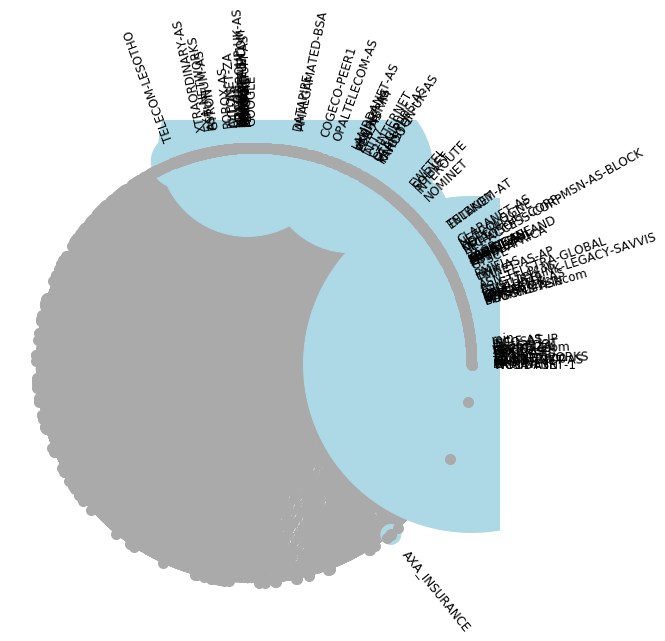

In [100]:
make_circular_graph(df_africa, 60, 10)

### Circular plot for Western Africa


TypeError: circular_layout() got an unexpected keyword argument 'k'

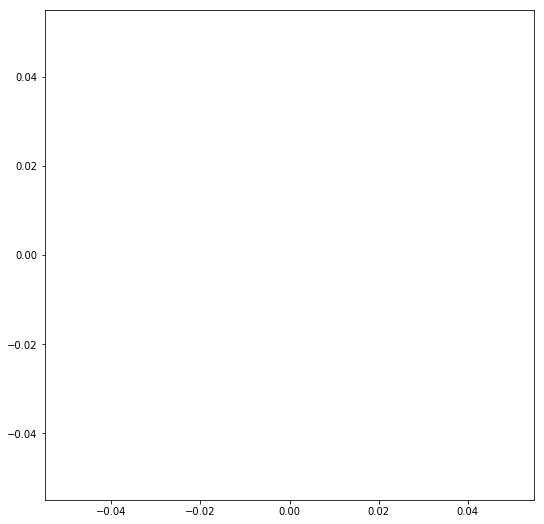

In [102]:
df_west = df_africa[df_africa.customer_cc.isin(wa) | df_africa.provider_cc.isin(wa)]
make_circular_graph(df_west, 1, 1)

### Circular plot for Eastern Africa

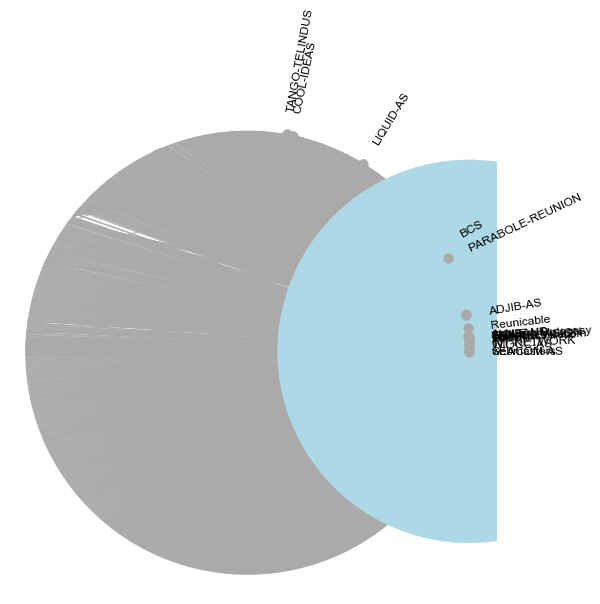

In [156]:
df_peering_east = df_peering[df_peering.customer_cc.isin(ea) | df_peering.provider_cc.isin(ea)]
make_circular_graph(df_peering_east, 20, 20)

### Circular plot for Southern Africa

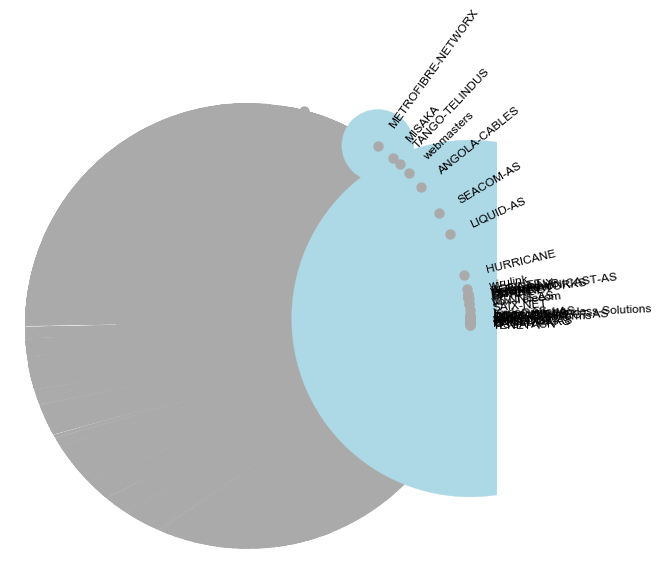

In [159]:
df_peering_south = df_peering[df_peering.customer_cc.isin(sa) | df_peering.provider_cc.isin(sa)]
make_circular_graph(df_peering_south, 30, 30)

### Circular plot for Northern Africa

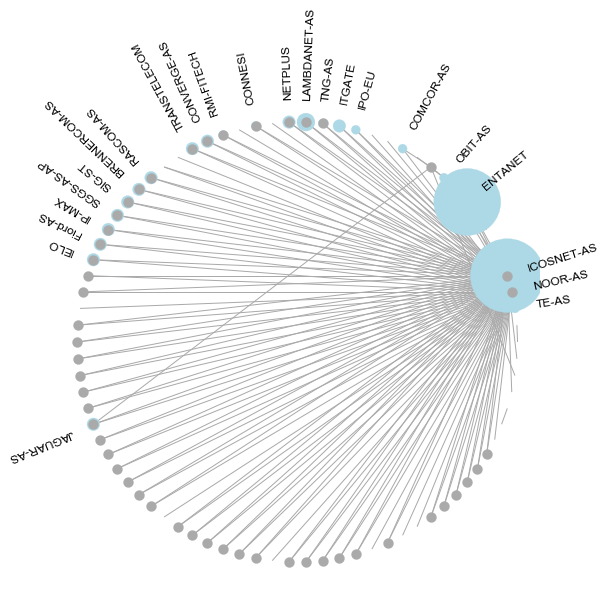

In [160]:
df_peering_north = df_peering[df_peering.customer_cc.isin(na) | df_peering.provider_cc.isin(na)]
make_circular_graph(df_peering_north, 1, 1)

### Circular plot for Middle Africa


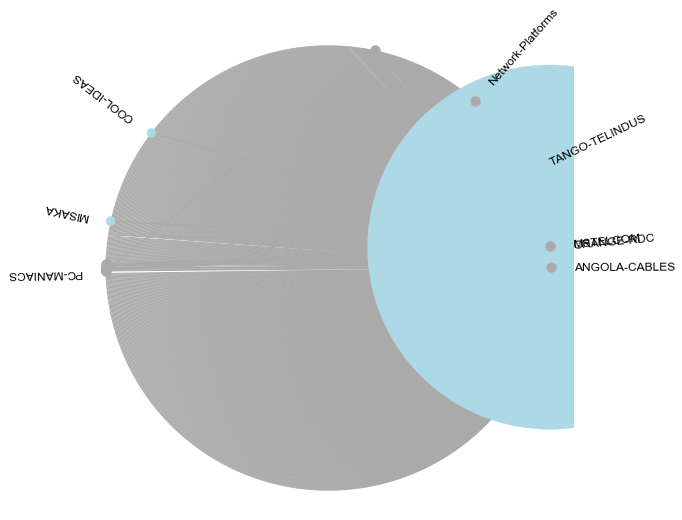

In [161]:
df_peering_middle = df_peering[df_peering.customer_cc.isin(ma) | df_peering.provider_cc.isin(ma)]
make_circular_graph(df_peering_middle, 1, 1)

In [126]:
print(nx.triangles(G,0))


15
